# Predicción de Ingresos — Resumen Ejecutivo

Objetivo: construir y evaluar un Random Forest que clasifique si una persona gana >50K/año, mostrando buenas prácticas en limpieza, EDA, transformaciones, modelo Random Forest y evaluación.

Datos: Adult Income Dataset (UCI). Fuente: https://archive.ics.uci.edu/dataset/2/adult

Notas rápidas:
- Contenido del proyecto, dependencias y versiones en `README.md` / `environment.yml`.
- Celdas costosas marcadas con "Nota: puede tardar".

## Carga de datos, librerías y primera inspección
Se carga el dataset con las librerias a usar en el notebook y se realiza una inspección inicial (info, head) para entender su estructura y tamaño.

In [2]:
# Limpieza y análisis de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ajuste de los datos
from sklearn.model_selection import train_test_split
from category_encoders import TargetEncoder
from sklearn.preprocessing import OneHotEncoder

# Creación del modelo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Evaluación del modelo
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Palette = ['#1f78b4','#b2df8a']
sns.set_palette(Palette)

%run pandas-missing-extension.ipynb

df = pd.read_csv('https://archive.ics.uci.edu/static/public/20/data.csv', sep = ',')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


## Limpieza de Datos
### Valores Nulos

In [3]:
df.missing.missing_variable_summary()
cols_missing = ['workclass', 'occupation', 'native-country']

for col in cols_missing:
    print(f'Valores únicos de {col}:', df[col].unique())
    print('=' * 50)

Valores únicos de workclass: ['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked' nan]
Valores únicos de occupation: ['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Craft-repair' 'Transport-moving'
 'Farming-fishing' 'Machine-op-inspct' 'Tech-support' '?'
 'Protective-serv' 'Armed-Forces' 'Priv-house-serv' nan]
Valores únicos de native-country: ['United-States' 'Cuba' 'Jamaica' 'India' '?' 'Mexico' 'South'
 'Puerto-Rico' 'Honduras' 'England' 'Canada' 'Germany' 'Iran'
 'Philippines' 'Italy' 'Poland' 'Columbia' 'Cambodia' 'Thailand' 'Ecuador'
 'Laos' 'Taiwan' 'Haiti' 'Portugal' 'Dominican-Republic' 'El-Salvador'
 'France' 'Guatemala' 'China' 'Japan' 'Yugoslavia' 'Peru'
 'Outlying-US(Guam-USVI-etc)' 'Scotland' 'Trinadad&Tobago' 'Greece'
 'Nicaragua' 'Vietnam' 'Hong' 'Ireland' 'Hungary' 'Holand-Netherlands' nan]


Al ver los valores únicos de cada columna, vemos que los valores faltantes están nombrados como "?" y "nan", entonces los reemplazamos por np.nan para tenerlos en una misma categoría.

In [4]:
df.replace('?', np.nan, inplace=True)
df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,age,0,48842,0.000000
1,workclass,2799,48842,5.730724
2,fnlwgt,0,48842,0.000000
3,education,0,48842,0.000000
4,education-num,0,48842,0.000000
5,marital-status,0,48842,0.000000
6,occupation,2809,48842,5.751198
7,relationship,0,48842,0.000000
8,race,0,48842,0.000000
9,sex,0,48842,0.000000


Vemos cómo los valores nulos en cada columna aumentaron en gran cantidad después de hacer el reemplazo. Ahora, lo que se hará será hacer otra imputación, pero esta vez convirtiendo los valores faltantes categóricos en una nueva categoría llamada `"Unknown"`, así no se pierde información y se puede seguir trabajando con esos datos.

In [5]:
df['workclass'] = df['workclass'].fillna('Unknown')
df['occupation'] = df['occupation'].fillna('Unknown')
df['native-country'] = df['native-country'].fillna('Unknown')
df.missing.missing_variable_summary()

,variable,n_missing,n_cases,pct_missing
0,age,0,48842,0.0
1,workclass,0,48842,0.0
2,fnlwgt,0,48842,0.0
3,education,0,48842,0.0
4,education-num,0,48842,0.0
5,marital-status,0,48842,0.0
6,occupation,0,48842,0.0
7,relationship,0,48842,0.0
8,race,0,48842,0.0
9,sex,0,48842,0.0


### Valores Duplicados

In [6]:
num_duplicados = df.duplicated().sum()
print(f"Número de filas duplicadas: {num_duplicados}")

Número de filas duplicadas: 29


Al ver que no son tantos datos duplicados, procedemos a eliminarlos ya que no afectará mucho el dataset y puede ayudar a mejorar el rendimiento del modelo.

In [7]:
df = df.drop_duplicates()
print(f"Número de filas duplicadas: {df.duplicated().sum()}")

df_processing = df.copy()

Número de filas duplicadas: 0


Finalmente, copiamos el dataframe limpio a una nueva variable para seguir trabajando con ella y no perder el dataframe original.

## Análisis Exploratorio de Datos (EDA)

### Análisis de Variable objetivo: `income`

Como primera parte del EDA, se realiza un análisis del dataset para entender las estadísticas descriptivas de las variables numéricas.

In [8]:
df_processing.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48813.000000,4.881300e+04,48813.000000,48813.000000,48813.000000,48813.000000
mean,38.647348,1.896679e+05,10.078688,1079.708705,87.554299,40.425051
std,13.709005,1.056062e+05,2.570257,7454.185982,403.118605,12.390954
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175550e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781400e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376200e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


Notamos que en las variables 'capital-gain' y 'capital-loss' hay una inconsistencia entre su rango intercuartílico y su valor máximo, lo que indica que hay muchos valores atípicos en esas variables.

In [9]:
df_processing['income'].unique()

array(['<=50K', '>50K', '<=50K.', '>50K.'], dtype=object)

Vemos que la variable objetivo tiene cuatro valores únicos, pero solamente deberían ser dos (<=50K y >50K). Entonces, procedemos a unificar los valores que son similares para tener solamente dos categorías y mostrar la cantidad de valores que hay en cada categoria.

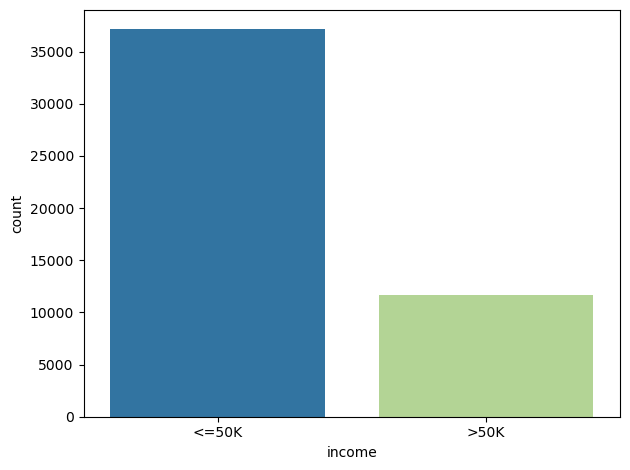

In [10]:
df_processing['income'] = df_processing['income'].str.strip('.')

sns.countplot(data=df_processing, x='income', hue='income')
plt.tight_layout()
plt.show()

Al hacer la unificación y ver la distribución de la variable objetivo, vemos que hay un desbalance en las clases, ya que la mayoría de los datos pertenecen a la clase <=50K. Para entender mejor cómo las variables numéricas se relacionan con este desbalance, analizaremos:

1. La distribución de edades por nivel de ingreso mediante un gráfico KDE, que nos mostrará si existen patrones o tendencias en la edad para cada grupo de ingreso.

2. La distribución de horas trabajadas por semana mediante un violin plot, que nos permitirá visualizar no solo la mediana y el rango, sino también la forma completa de la distribución para cada nivel de ingreso.

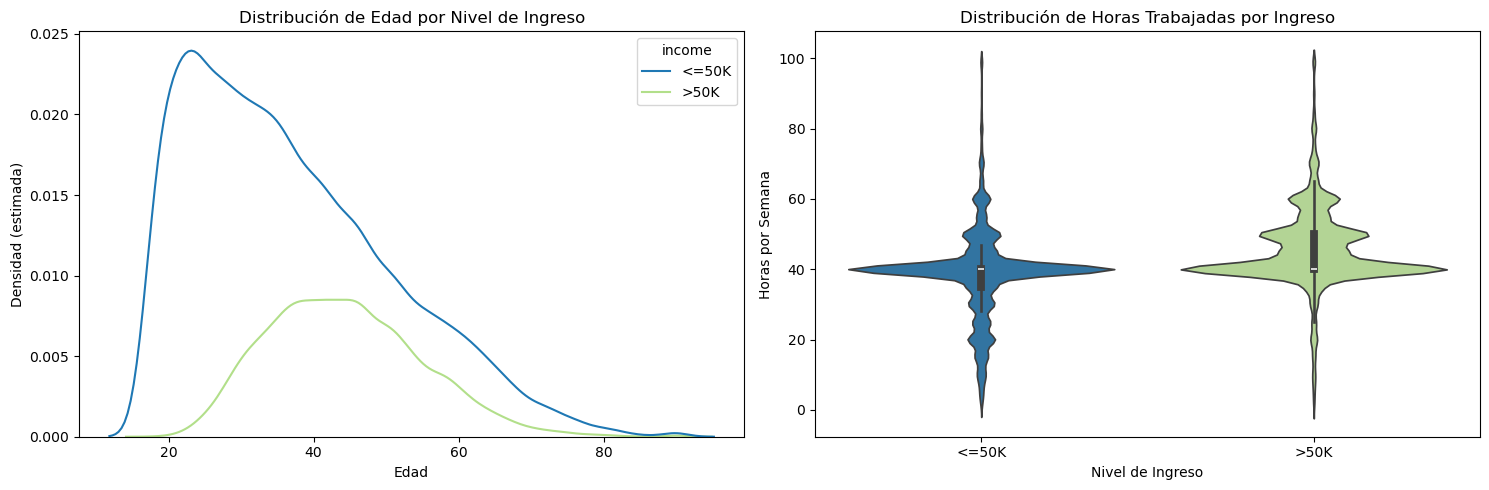

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# KDE plot para edad por ingreso
sns.kdeplot(data=df_processing, x='age', hue='income', ax=ax1)
ax1.set_title('Distribución de Edad por Nivel de Ingreso')
ax1.set_xlabel('Edad')
ax1.set_ylabel('Densidad (estimada)')

# Violin plot para horas trabajadas
sns.violinplot(data=df_processing, x='income', y='hours-per-week', hue='income',
               ax=ax2, palette=Palette, legend=False)
ax2.set_title('Distribución de Horas Trabajadas por Ingreso')
ax2.set_xlabel('Nivel de Ingreso')
ax2.set_ylabel('Horas por Semana')

plt.tight_layout()
plt.show()

**Distribución de Edad (KDE Plot):**
- Las personas con ingresos <=50K son mayoría y su distribución se concentra entre los 20 y 40 años, con un pico pronunciado alrededor de los 25 años.
- Las personas con ingresos >50K presentan una distribución desplazada hacia la derecha, con mayor densidad entre 35 y 55 años, y prácticamente inexistente en edades muy jóvenes.
- Esto sugiere que los ingresos altos son más comunes en edades medias, probablemente debido a la acumulación de experiencia laboral.

**Distribución de Horas Trabajadas (Violin Plot):**
- Ambos grupos presentan una concentración fuerte alrededor de 40 horas semanales, lo cual coincide con una jornada laboral estándar.
- Sin embargo, el grupo >50K muestra una distribución más extendida hacia valores altos (más de 50 horas), indicando que quienes ganan más tienden a trabajar más horas.
- En cambio, el grupo <=50K tiene una mayor dispersión hacia abajo (menos de 40 horas), reflejando posiblemente empleos de medio tiempo o menos estables.

Estas visualizaciones sugieren que tanto la edad como las horas trabajadas son factores importantes que pueden influir en el nivel de ingresos de una persona. Ahora, para un análisis completo, continuaremos con las variables categóricas, ya que, estas son mayoría en este dataset y tienen alta cardinalidad.

## Análisis de Variables Categóricas

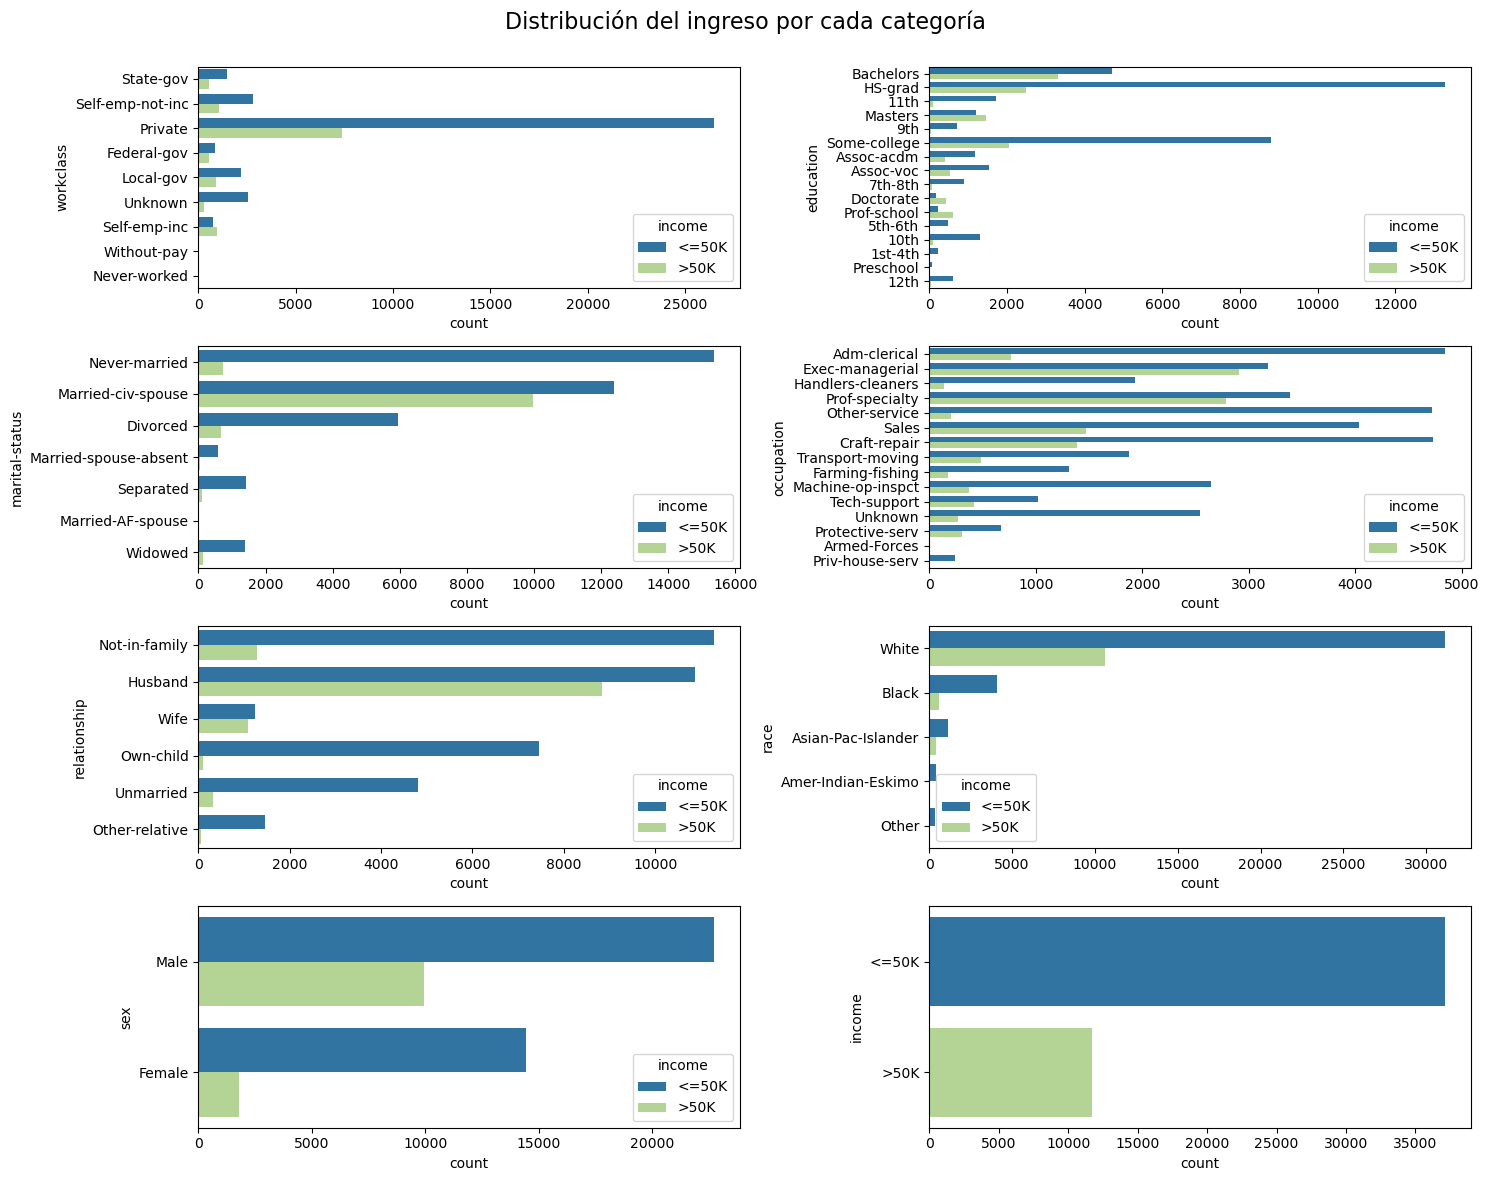

In [12]:
cols_categorical = df_processing.select_dtypes(include='object').drop('native-country', axis=1)
fig, ax = plt.subplots(4,2, figsize=(15,12))
for col, i in zip(cols_categorical, ax.flatten()):
    sns.countplot(data=df_processing, y=col, ax=i, hue='income')

fig.suptitle('Distribución del ingreso por cada categoría\n', fontsize=16)
plt.tight_layout()
plt.show()

Notamos que muchas de las variables categóricas tienen un número elevado de categorías, lo que puede complicar la codificación y el modelado. En este análisis hemos incluido todas las variables categóricas excepto `native-country`, que se ha excluido temporalmente debido a su alta cardinalidad (la trataremos por separado con técnicas apropiadas como Target Encoding).

Además, se observa de forma consistente que la clase `>50K` aparece con mucha menos frecuencia dentro de cada categoría, lo que confirma y refuerza el desbalance de la variable objetivo que ya habíamos detectado.

A continuación procederemos a analizar las variables numéricas para estudiar sus distribuciones y detectar outliers. Para ello utilizaremos boxplots por nivel de ingreso y, cuando proceda, transformaciones (ej. recorte por IQR) para decidir el tratamiento más apropiado.

## Análisis de Variables Numéricas

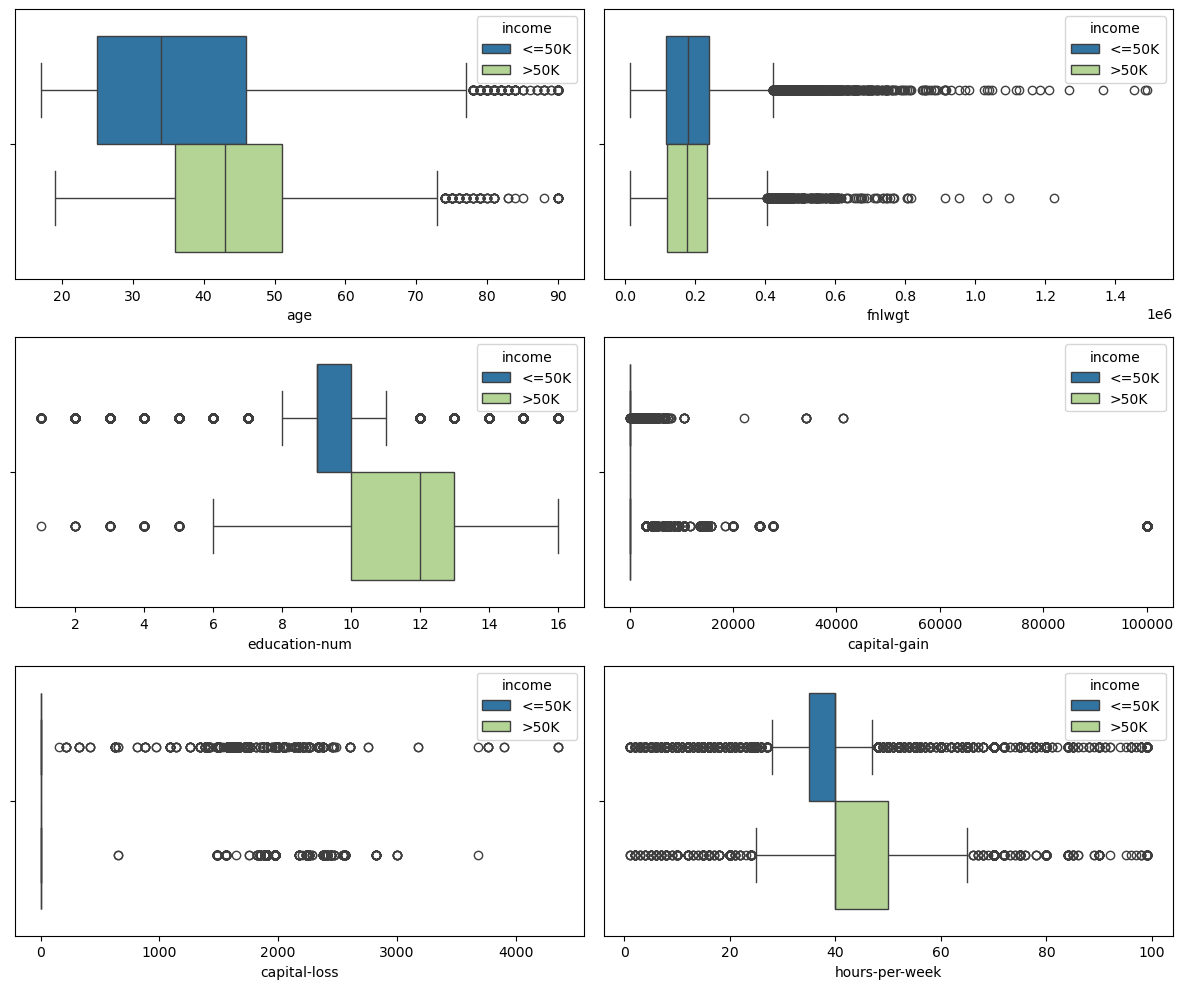

In [13]:
cols_numeric = df_processing.select_dtypes(include=np.number)
fig, ax = plt.subplots(3,2, figsize=(12,10))

for col, i in zip(cols_numeric, ax.flatten()):
    sns.boxplot(data=df_processing, x=col, ax=i, hue='income')

plt.tight_layout()
plt.show()

Notamos que las distribuciones de las variables numéricas presentan outliers, especialmente en la clase <=50K. Sin embargo, dado que utilizaremos Random Forest como algoritmo de modelado, estos valores atípicos no representan un problema significativo, ya que:
1. Random Forest es robusto frente a outliers por su naturaleza basada en árboles
2. Estos valores extremos podrían contener información valiosa sobre patrones específicos de ingresos
3. No es necesario realizar transformaciones o eliminaciones que podrían resultar en pérdida de información

Notamos que las distribuciones de las variables numéricas presentan outliers, especialmente en la clase <=50K. Estos outliers pueden afectar negativamente el rendimiento del modelo, por lo que es importante identificarlos y considerar su eliminación o tratamiento adecuado.

<Axes: >

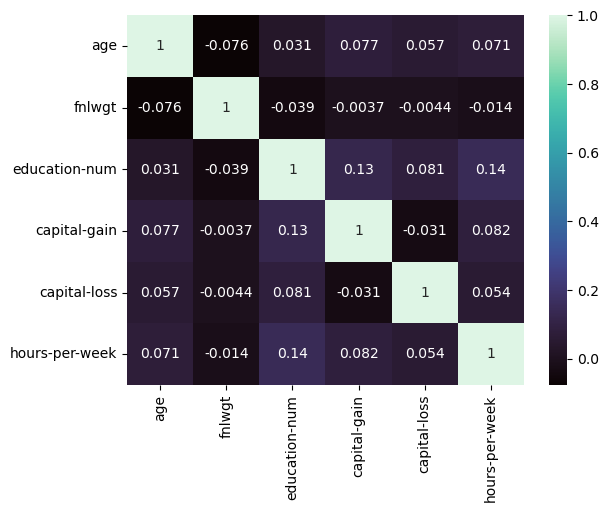

In [17]:
sns.heatmap(cols_numeric.corr(), annot=True, cmap='mako')

El heatmap de correlación entre variables numéricas revela varios aspectos importantes:

No se observa multicolinealidad significativa entre las variables (todas las correlaciones son < 0.3), lo cual es beneficioso para el modelo ya que:
   - Cada variable aporta información única
   - No hay redundancia que pueda afectar la interpretabilidad
   - No es necesario eliminar variables por correlación alta

Esta baja correlación entre predictores numéricos sugiere que cada variable podría contribuir de manera independiente al poder predictivo del modelo Random Forest.

A continuación, procederemos con la transformación y separación de los datos, donde:
1. Convertiremos las variables categóricas usando One-Hot Encoding para aquellas con pocas categorías y Target Encoding para las de alta cardinalidad
2. Separaremos los datos en conjuntos de entrenamiento y prueba, manteniendo la proporción de clases mediante estratificación
3. Aplicaremos las transformaciones asegurando que no haya fuga de información entre train y test

#### Transformación y Separación de Datos

In [20]:
df_processing.select_dtypes(include='object').nunique().sort_values(ascending=True)

sex                2
income             2
race               5
relationship       6
marital-status     7
workclass          9
occupation        15
education         16
native-country    42
dtype: int64

In [22]:
# Separación de Características y Variable Objetivo
X = df_processing.drop(['income', 'education'], axis=1) 
y= df_processing['income'] 

# División del Conjunto de Datos (train/test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convertir y a numérico para TE
y_train_numeric = y_train.map({'<=50K': 0, '>50K': 1})
y_test_numeric = y_test.map({'<=50K': 0, '>50K': 1})

# Selección y transformación de columnas categóricas para TE
te_country = TargetEncoder()
te_occupation = TargetEncoder()
X_train['native-country'] = te_country.fit_transform(X_train['native-country'], y_train_numeric)
X_test['native-country'] = te_country.transform(X_test['native-country'])
X_train['occupation'] = te_occupation.fit_transform(X_train['occupation'], y_train_numeric)
X_test['occupation'] = te_occupation.transform(X_test['occupation'])

# Selección y transformación de columnas categóricas para OHE
cat_cols = ['sex', 'race', 'relationship', 'marital-status', 'workclass']
ohe = OneHotEncoder(drop='first', sparse_output=False) # drop para evitar multicolinealidad
X_train_ohe = ohe.fit_transform(X_train[cat_cols]) # fit y transform en train
X_test_ohe = ohe.transform(X_test[cat_cols]) # solo transform en test

# Convierte a DataFrame y combina con numéricas
X_train_ohe_df = pd.DataFrame(X_train_ohe, columns=ohe.get_feature_names_out(cat_cols), index=X_train.index)
X_test_ohe_df = pd.DataFrame(X_test_ohe, columns=ohe.get_feature_names_out(cat_cols), index=X_test.index)

# Combina todas las características preprocesadas
num_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
te_cols = ['native-country', 'occupation']
X_train_final = pd.concat([X_train[num_cols], X_train[te_cols],X_train_ohe_df], axis=1)
X_test_final = pd.concat([X_test[num_cols], X_test[te_cols],X_test_ohe_df], axis=1)

En esta celda de código, se realiza una serie de pasos para las transformaciones y separaciones de los datos, los cuales son los siguientes:

1. **Separación de Características y Variable Objetivo**: Se separan las características (X) de la variable objetivo (y). La variable objetivo es 'income', que indica si una persona gana más de 50K al año. También, se eliminó la columna 'education' ya que 'education-num' ya la representa numéricamente.

2. **División del Conjunto de Datos**: Se divide el conjunto de datos en conjuntos de entrenamiento y prueba utilizando `train_test_split`. El 80% de los datos se utilizan para entrenamiento y el 20% para prueba, con el parámetro `stratify=y` para mantener la proporción de clases en ambos conjuntos y `random_state=42` para asegurar la reproducibilidad.

3. **Convertir y a numérico para TE**: Se convierte la variable objetivo `y` a formato numérico (0 y 1) para facilitar el uso de Target Encoding en las variables categóricas.

4. **Codificación de Variables Categóricas**:
   - **Target Encoding**: Se aplica Target Encoding a las variables categóricas con alta cardinalidad ('native-country' y 'occupation') utilizando `TargetEncoder` de la librería `category_encoders`. Esta técnica reemplaza cada categoría con la media de la variable objetivo para esa categoría.
   - **One-Hot Encoding**: Se aplica One-Hot Encoding a las variables categóricas con baja cardinalidad ('sex', 'race', 'relationship', 'marital-status', 'workclass') utilizando `OneHotEncoder` de sklearn. Esta técnica crea nuevas columnas binarias para cada categoría, lo que es útil para variables con pocas categorías.

5. **Combinación de Datos Transformados**: Finalmente, se combinan las columnas numéricas y las columnas transformadas (tanto de Target Encoding como de One-Hot Encoding) para crear los conjuntos finales de entrenamiento y prueba (`X_train_final` y `X_test_final`), que están listos para ser utilizados en el modelo de Random Forest.

## Creación del Modelo

In [24]:
# Nota: puede tardar

#Configuración del modelo 
rf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_grid = {'n_estimators': [100, 200], 'max_depth': [10, None]}
best_model = GridSearchCV(rf, param_grid=param_grid, cv = 3, scoring='f1_macro')

# Proceso de entrenamiento
best_model.fit(X_train_final, y_train_numeric)
y_train_predict = best_model.predict(X_train_final)
y_test_predict = best_model.predict(X_test_final)

En esta sección implementaremos un modelo de Random Forest con las siguientes características y consideraciones:

1. **Configuración del modelo base**:
   - Utilizamos `RandomForestClassifier` con `class_weight='balanced'` para manejar el desbalance de clases
   - Fijamos `random_state=42` para reproducibilidad de resultados

2. **Búsqueda de hiperparámetros**:
   - Implementamos `GridSearchCV` con validación cruzada (cv=3)
   - Parámetros a optimizar:
     * `n_estimators`: [100, 200] (número de árboles)
     * `max_depth`: [10, None] (profundidad máxima de los árboles)
   - Métrica de evaluación: 'f1_macro' (adecuada para datos desbalanceados)

3. **Proceso de entrenamiento**:
   - Ajuste del modelo usando los datos de entrenamiento transformados
   - Predicciones en conjuntos de train y test para evaluar generalización

El objetivo es encontrar un balance entre la complejidad del modelo y su capacidad de generalización, prestando especial atención al manejo del desbalance de clases.

## Evaluación del Modelo

In [25]:
train_accuracy = accuracy_score(y_train_numeric, y_train_predict)
test_accuracy = accuracy_score(y_test_numeric, y_test_predict)

print('El accuracy de train es: ', train_accuracy)
print('El accuracy de test es: ', test_accuracy)

El accuracy de train es:  0.9999487836107555
El accuracy de test es:  0.8588548601864181


<Figure size 1200x600 with 0 Axes>

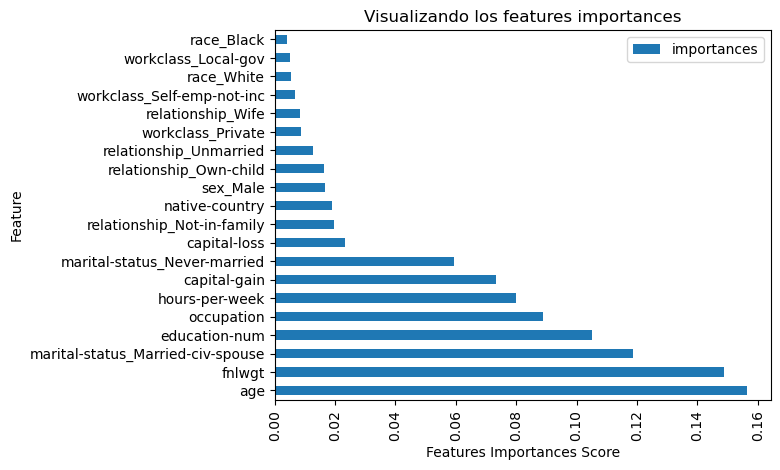

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7426
           1       0.75      0.62      0.68      2337

    accuracy                           0.86      9763
   macro avg       0.82      0.78      0.79      9763
weighted avg       0.85      0.86      0.85      9763

AUC-ROC: 0.9112212973165211


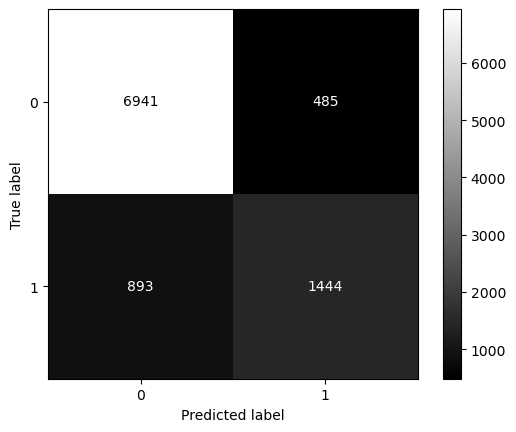

In [26]:
importances_rf = pd.DataFrame(
    {'feature': list(X_train_final.columns), 'importances': best_model.best_estimator_.feature_importances_}
).sort_values('importances', ascending=False)

plt.figure(figsize=(12,6))
importances_rf.head(20).plot.barh(x='feature', y='importances')

plt.xlabel('Features Importances Score')
plt.ylabel('Feature')
plt.title('Visualizando los features importances')
plt.xticks(rotation=90)
plt.show()

print(classification_report(y_test_numeric, y_test_predict))
print('AUC-ROC:', roc_auc_score(y_test_numeric, best_model.predict_proba(X_test_final)[:, 1]))

cm = confusion_matrix(y_test_numeric, y_test_predict)
disp = ConfusionMatrixDisplay(cm)
disp.plot(cmap='gray')
plt.show()

## Conclusión del Proyecto: Predicción de Ingresos con Random Forest

El modelo de **Random Forest** fue entrenado para predecir si una persona gana más de 50 000 USD anuales a partir de variables sociodemográficas del *Adult Census Income Dataset*.  
El modelo demostró un **rendimiento sólido y equilibrado**, con una **excelente capacidad de discriminación entre niveles de ingreso**.

---

### Resultados del Modelo
- **Accuracy (train):** 0.9999  
- **Accuracy (test):** 0.8589  
- **AUC-ROC:** 0.91  
- **F1-score (<=50K):** 0.91  
- **F1-score (>50K):** 0.68  

El modelo logra una **exactitud del 86 %** en datos de prueba y un **AUC de 0.91**, reflejando una gran capacidad de separación entre ambas clases.  
La ligera diferencia entre *train* y *test* sugiere un **leve sobreajuste**, común en modelos complejos como Random Forest, pero no afecta significativamente su generalización.

---

### Análisis del Desempeño
La matriz de confusión muestra que el modelo identifica correctamente la mayoría de los casos con ingresos menores o iguales a 50K (recall = 0.93), aunque presenta mayor dificultad para reconocer los ingresos altos (recall = 0.62), lo cual se debe al **desequilibrio de clases**.

Aun así, el modelo mantiene un rendimiento general competitivo y coherente con la distribución real de los datos.

---

### Importancia de las Variables
Las variables más influyentes en las predicciones fueron:

- **age** → mayor edad se asocia con más experiencia y mayores ingresos.  
- **fnlwgt** → representa la ponderación poblacional.  
- **marital-status (Married-civ-spouse)** → fuerte correlación con mayores ingresos.  
- **education-num** → relación directa entre educación y nivel salarial.  
- **occupation** y **hours-per-week** → reflejan tipo y dedicación laboral.  

Estas variables reflejan patrones socioeconómicos coherentes y confirman la relevancia de factores educativos, laborales y demográficos.

---

### Interpretación Global
El modelo:
- Captura **relaciones no lineales complejas** entre las variables.  
- Es **robusto frente a outliers** y valores extremos.  
- Presenta **alta capacidad de generalización** y coherencia con los datos reales.  
- Aprovecha adecuadamente las transformaciones logarítmicas aplicadas a variables con sesgo extremo.

---

### Conclusión General
- El modelo de **Random Forest** alcanza un desempeño sólido (AUC = 0.91, accuracy = 0.86) y demuestra gran capacidad para predecir el nivel de ingreso.  
- Las variables más importantes —edad, educación, estado civil y ocupación— reflejan patrones socioeconómicos reales y relevantes.  
- A pesar de un leve sobreajuste, el modelo muestra **alta fiabilidad y utilidad práctica** para tareas predictivas o estudios de comportamiento socioeconómico.